In [1]:
import pandas as pd
import numpy as np
from utilities.gex_parser import parse_gex_file
import matplotlib.pyplot as plt

from SimPEG.electromagnetics import time_domain as tdem

/var/folders/84/p2kwn61561lg6qxvs6gwhy780000gp/T/ipykernel_7657/1777680153.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
data_file = pd.read_csv('../data/MCWD3_dat.xyz')
# you can alternatively use pandas to directly fetch this file from the internet
# data_file = pd.read_csv("https://github.com/simpeg/segns-2024-tutorial/raw/main/data/MCWD3_dat.xyz")
data_file
data_file[data_file==9999] = np.NaN
gex_file = parse_gex_file('../data/20170606_337m2_Cal_DualWaveform_60Hz_414_412_418.gex')

In [3]:
gex_file

{'General': {'Description': 'Test geometry file',
  'GPSDifferentialPosition1': array([11.68,  2.79, -0.16]),
  'GPSPosition1': array([11.68,  2.79, -0.16]),
  'GPSPosition2': array([10.51,  3.95, -0.16]),
  'AltimeterPosition1': array([12.94,  1.79, -0.12]),
  'AltimeterPosition2': array([12.94, -1.79, -0.12]),
  'InclinometerPosition1': array([12.79,  1.64, -0.12]),
  'InclinometerPosition2': array([12.79,  1.64, -0.12]),
  'RxCoilPosition1': array([-13.25,   0.  ,  -2.  ]),
  'LoopType': 72,
  'FrontGateDelay': 2.5e-06,
  'TxLoopArea': 337.04,
  'NumberOfTurnsLM': 1,
  'NumberOfTurnsHM': 4,
  'RxCoilLPFilter1': array([9.9e-01, 2.1e+05]),
  'TxLoopPoints': array([[-12.64,  -2.13],
         [ -6.15,  -8.59],
         [  5.74,  -8.59],
         [ 11.13,  -3.19],
         [ 11.13,   3.19],
         [  5.74,   8.59],
         [ -6.15,   8.59],
         [-12.64,   2.13]]),
  'Waveforms': {'HM': {'time': array([-3.22220e-02, -3.17433e-02, -3.11906e-02, -3.04936e-02,
           -2.96885e-02

In [4]:
n_lm_gates = gex_file['Channel1']['NoGates'] - gex_file['Channel1']['RemoveInitialGates']
n_hm_gates = gex_file['Channel2']['NoGates'] - gex_file['Channel2']['RemoveInitialGates']

In [5]:
line_no = 206301
line_grouping = data_file.groupby('LINE_NO')
line = line_grouping.get_group(line_no)

In [6]:
lm_data = line.iloc[:, 9:9+n_lm_gates]
lm_std = line.iloc[:, 9+n_lm_gates:9+2*n_lm_gates]
hm_data = line.iloc[:, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates]
hm_std = line.iloc[:,  9+2*n_lm_gates + n_hm_gates:]

In [7]:
# select a single sounding along that line
# Record 5590
station = line[line.RECORD==5590]
station_lm_data = station.iloc[0, 9:9+n_lm_gates].to_numpy()
station_lm_std = station.iloc[0, 9+n_lm_gates:9+2*n_lm_gates].to_numpy()
station_hm_data = station.iloc[0, 9+2*n_lm_gates:9+2*n_lm_gates + n_hm_gates].to_numpy()
station_hm_std = station.iloc[0,  9+2*n_lm_gates + n_hm_gates:].to_numpy()

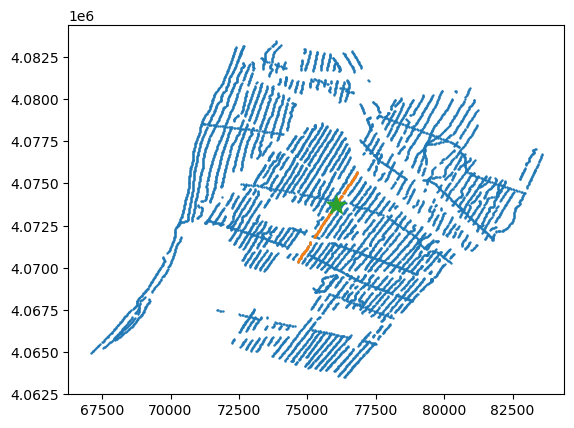

In [8]:
plt.scatter(data_file.UTMX, data_file.UTMY, s=0.5)
plt.scatter(line.UTMX, line.UTMY, s=0.5)
plt.scatter(station.UTMX, station.UTMY, s=200, marker='*')

Text(0.5, 0, 'Northing')

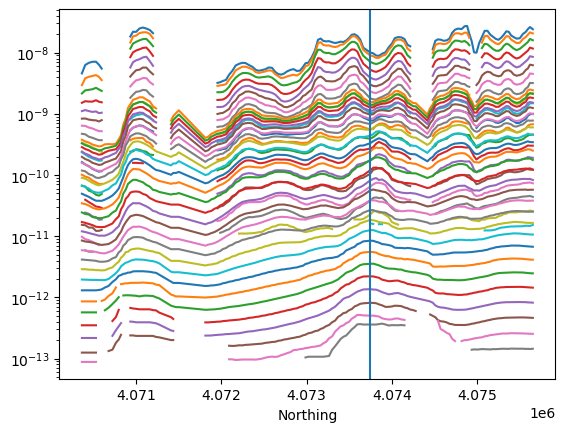

In [9]:
plt.semilogy(line.UTMY, lm_data);
plt.semilogy(line.UTMY, hm_data);
plt.axvline(station.UTMY.iloc[0]);
plt.xlabel('Northing')

In [10]:
gate_centers = gex_file['General']['GateTimes']['center']

channel_info = gex_file['Channel1']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
lm_times = gate_centers[first_gate:last_gate] + shift + delay

channel_info = gex_file['Channel2']
shift = channel_info['GateTimeShift']
delay = channel_info['MeaTimeDelay']
first_gate = channel_info['RemoveInitialGates']
last_gate = channel_info['NoGates']
hm_times = gate_centers[first_gate:last_gate] + shift + delay

Some of the station data are NaN's (which represent no data), Let's remove them from our consideration:

In [11]:
lm_good_data = ~np.isnan(station_lm_data)
hm_good_data = ~np.isnan(station_hm_data)

lm_times = lm_times[lm_good_data]
hm_times = hm_times[hm_good_data]

station_lm_data = station_lm_data[lm_good_data]
station_lm_std = station_lm_std[lm_good_data]
station_hm_data = station_hm_data[hm_good_data]
station_hm_std = station_hm_std[hm_good_data]

# and of course reset our counts too
n_lm_gates = len(lm_times)
n_hm_gates = len(hm_times)

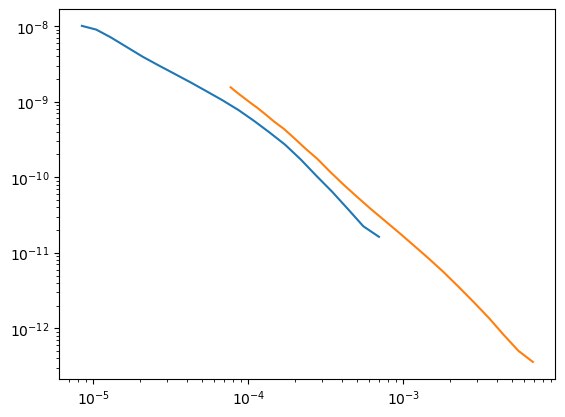

In [12]:
plt.loglog(lm_times, station_lm_data)
plt.loglog(hm_times, station_hm_data)

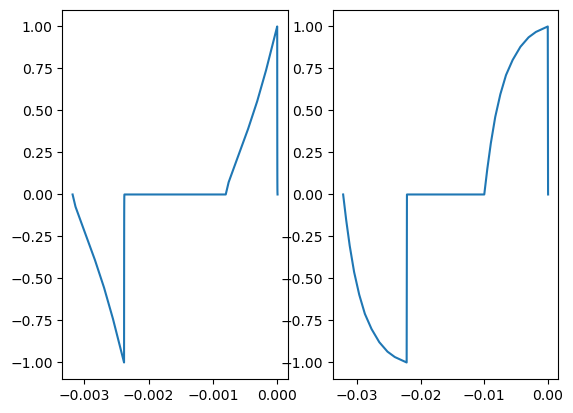

In [13]:
waves = gex_file['General']['Waveforms']
lm_wave_time = waves['LM']['time']
lm_wave_form = waves['LM']['form']
hm_wave_time = waves['HM']['time']
hm_wave_form = waves['HM']['form']
plt.subplot(121)
plt.plot(lm_wave_time, lm_wave_form)
plt.subplot(122)
plt.plot(hm_wave_time, hm_wave_form)

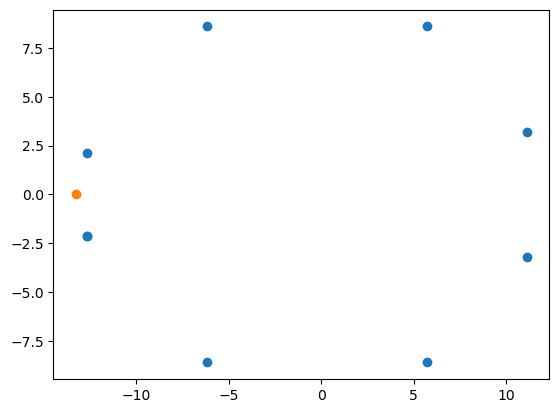

In [14]:
tx_shape = np.pad(gex_file['General']['TxLoopPoints'], (0, 1))
tx_shape[-1] = tx_shape[0]
rx_offset = gex_file['General']['RxCoilPosition1']
plt.scatter(*tx_shape[:, :-1].T)
plt.scatter(*rx_offset[:-1])

In [15]:
tx_loc = tx_shape + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.INVALT.iloc[0]]
rx_loc = rx_offset + [station.UTMX.iloc[0], station.UTMY.iloc[0], station.INVALT.iloc[0]]

# Low moment:
rx_lm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, lm_times, orientation='z'
)

lm_wave = tdem.sources.PiecewiseLinearWaveform(lm_wave_time, lm_wave_form)

src_lm = tdem.sources.LineCurrent(rx_lm, tx_loc, waveform=lm_wave)

# high moment
rx_hm = tdem.receivers.PointMagneticFluxTimeDerivative(
    rx_loc, hm_times, orientation='z'
)

hm_wave = tdem.sources.PiecewiseLinearWaveform(hm_wave_time, hm_wave_form)

src_hm = tdem.sources.LineCurrent(rx_hm, tx_loc, waveform=hm_wave)

# combine them together into a single survey

srv = tdem.Survey([src_lm, src_hm])

In [16]:
#first a simple test
thicknesses = []
conductivities = [1E-2]

In [17]:
tx_area = gex_file['General']['TxLoopArea']

In [18]:
sim = tdem.Simulation1DLayered(srv, sigma=conductivities, thicknesses=thicknesses)

In [19]:
#sim.thicknesses = [10]
#sim.sigma = [2E-1, 3E-1]
pre = -sim.dpred(None)
pre_lm = pre[:n_lm_gates]
pre_hm = pre[n_lm_gates:]

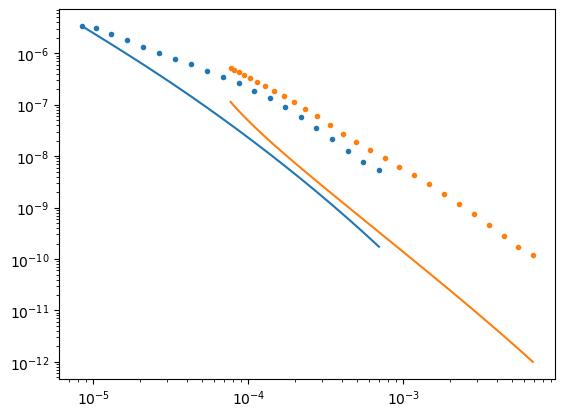

In [20]:
plt.loglog(lm_times, pre_lm)
plt.loglog(hm_times, pre_hm)
plt.loglog(lm_times, station_lm_data*tx_area, color='C0', marker='.', linestyle='')
plt.loglog(hm_times, station_hm_data*tx_area, color='C1', marker='.', linestyle='')

# Setup an inversion

An inversion has many pieces that we must all setup for simpeg.

There are:
* `Map`: Objects that tell simpeg what to invert for.
* `Data`: a container for the observed data, its standard deviation, and the survey.
* Objective Functions, which describe the function we minimize to perform the inversion.
    * `DataMisfit`: How we measure the fitness of a model to the observed data.
    * `Regularization`: A measure of the simplicity of a model.
* `Minimization Routines`: Which method we use to iteratively minize the objective function.
* `Directives`: Operations that adjust parameters in the objective function as the inversion proceeds.
* `InverseProblem`: An object which groups all of these together and performs the inversion.

We will start by describing parametric inversions for simple 1D models, where the number of layers we invert for is much less than the number of data.

## Maps
This is how we tell simpeg what to invert for.

Maps define how we go from our inversion model to the physical properties.

In [21]:
from SimPEG import maps

for example, this is a simple map that will transform its input according to:
$$out = e^{in}$$

In [22]:
exp_map = maps.ExpMap()
exp_map * np.array([-5])

array([0.00673795])

This map is particularly useful for solving for conductivity for two reasons:
1) Generally conductivity varies on a logarithmic scale
2) We do not need to handle positivity constraints while minimizing

We use maps in simpeg to tell the simulations what we will be inverting for, let's start by just inverting for a single conductivity.

Let's setup a new simulation that does this, we can re-use our previous survey object.

In [23]:
sim_inv1 = tdem.Simulation1DLayered(srv, sigmaMap=exp_map)

In [88]:
sim_inv1.model = np.log(np.r_[1E-5])
sim_inv1.sigma

array([1.e-05])

## Data
We need to create a container for the data, things to remember about here:

* The processed data were normalized by the transmitter area.
* There is a sign difference in the convention for SimPEG and the processed data
* The standard deviations are actually relative errors.

In [26]:
from SimPEG import data

dobs = -tx_area * np.r_[station_lm_data, station_hm_data]
rel_err = np.r_[station_lm_std, station_hm_std]
data_container = data.Data(srv, dobs=dobs, relative_error=rel_err)
data_container.nD

47

Since the data container knows about the survey, we can index it
with sources and receivers to retrieve the data associated with that pair.

This is particularly useful to ensure that you have passed your observed data in the order that `SimPEG` expects it.

In [27]:
data_container[src_hm, rx_hm]

array([-5.22984968e-07, -4.73709720e-07, -4.26490416e-07, -3.77484800e-07,
       -3.26898466e-07, -2.79099454e-07, -2.29200682e-07, -1.83201462e-07,
       -1.47401074e-07, -1.11199607e-07, -8.10783424e-08, -5.90797416e-08,
       -4.01515752e-08, -2.73898926e-08, -1.88300878e-08, -1.29598621e-08,
       -9.01211256e-09, -6.21602872e-09, -4.22007784e-09, -2.84000015e-09,
       -1.86898791e-09, -1.18900971e-09, -7.44015800e-10, -4.58913664e-10,
       -2.74300004e-10, -1.69399674e-10, -1.21098472e-10])

## Objective functions

We will start by defining just a simple data misfit function, it needs to know how to compute data, and the data set you want to match.

In [28]:
from SimPEG.data_misfit import L2DataMisfit
phi_d_1 = L2DataMisfit(data=data_container, simulation=sim_inv1)

We can evaluate the data misfit of a particular model by calling this object. (It also knows how to do derivative and (approximate) Hessian operations needed for minimization).

In [29]:
m_0 = np.r_[-2] * np.log(10)  # sigma = 1E-2 S/m

phi_d_1(m_0)

10162.566345105502

If we wanted to know the best fitting halfspace for this data we could simply minimze this function. Let's grab a Gauss Newton minimizer.

In [30]:
from SimPEG import optimization

In [31]:
minimizer = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

Define our inverse problem to be minimized:
One odd quirk of a SimPEG minimization is that we must pass a regularization object to our inverse problem. However we can set `beta=0` to ignore it.

In [33]:
from SimPEG import regularization, inverse_problem
import discretize

empty_reg = regularization.Smallness(discretize.TensorMesh([1]))
# note we needed to pass a mesh that had a single cell
# in it because our model has 1 value.
inv_prob_1 = inverse_problem.BaseInvProblem(
    phi_d_1, reg=empty_reg, opt=minimizer, beta=0.0
)

In [34]:
from SimPEG import inversion
inv1 = inversion.BaseInversion(inv_prob_1, [])

# Run inversion
recovered_model = inv1.run(m_0)

SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  1.02e+04  0.00e+00  1.02e+04    3.00e+03      0              
   1  0.00e+00  1.23e+03  3.21e+00  1.23e+03    2.34e+03      0              
   2  0.00e+00  5.98e+02  4.33e+00  5.98e+02    5.49e+02      0   Skip BFGS  
   3  0.00e+00  5.76e+02  4.54e+00  5.76e+02    1.14e+02      0   Skip BFGS  
   4  0.00e+00  5.75e+02  4.58e+00  5.75e+02    2.33e+01      0   Skip BFGS  
   5  0.00e+00  5.75e+02  4.58e+00  5.75e+02  

In [35]:
sim_inv1.sigmaMap * recovered_model

array([0.20663495])

In [36]:
# This function returns a data object
# (so we can easily index it with receivers for plotting)
data_pre = sim_inv1.make_synthetic_data(recovered_model)

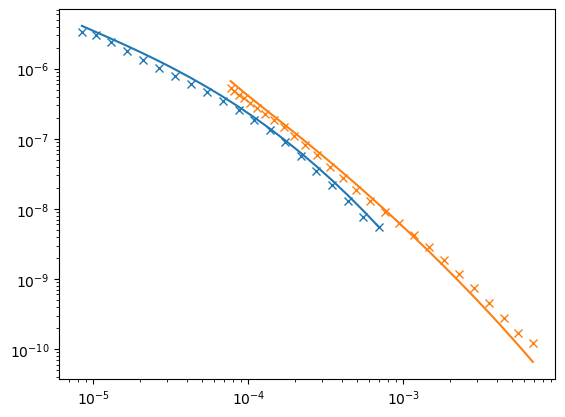

In [37]:
plt.loglog(lm_times, -data_pre[src_lm, rx_lm])
plt.loglog(hm_times, -data_pre[src_hm, rx_hm])

plt.loglog(
    lm_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
)
plt.loglog(
    hm_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
)

clearly a 1D model fits this reasonably well (in general), can we do better?

How do we solve for a simple layered model? We need to tell simpeg to invert for both conductivity and thickness.

Since we also need to ensure thicknesses are positive, lets use another `ExpMap` for them, but now our `model` consists of both values representing conductivity and thicknesses, so we need to tell SimPEG which parts correspond to each of them. There is a simple helper class to construct these called a `Wires`. It is very simple it says the first `X` values correspond to part 1, the next `Y` correspong to part 2.

In [38]:
n_layers = 2
wire_map = maps.Wires(('sigma',n_layers), ('thicknesses', n_layers-1))

It contains to projection maps which split the model into its conductivities and thickness portions

In [39]:
sigma_map = exp_map * wire_map.sigma
thick_map = exp_map * wire_map.thicknesses

In [40]:
# let's use the best fitting half-space as our initial model
sigma_0_2 = np.full(n_layers, recovered_model[0])
h_0_2 = np.log(np.full(n_layers-1, 10))
m_0_2 = np.r_[sigma_0_2, h_0_2]

sim_inv2 = tdem.Simulation1DLayered(srv, sigmaMap=sigma_map, thicknessesMap=thick_map)

In [41]:

phi_d_2 = L2DataMisfit(data=data_container, simulation=sim_inv2)

# create all of the same components of the inversion problem as before
minimizer2 = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)


empty_reg = regularization.Smallness(discretize.TensorMesh([n_layers + (n_layers -1) ]))
# note we needed to pass a mesh that had a 2*n_layers - 1 cells
# in it because our model has 2*n_layer - 1 values.
inv_prob_2 = inverse_problem.BaseInvProblem(
    phi_d_2, reg=empty_reg, opt=minimizer, beta=0.0
)

In [42]:
inv2 = inversion.BaseInversion(inv_prob_2, [])

# Run inversion
recovered_model_2 = inv2.run(m_0_2)

The callback on the InexactGaussNewton Optimization was replaced.
SimPEG.InvProblem will set Regularization.reference_model to m0.

                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  0.00e+00  5.75e+02  0.00e+00  5.75e+02    1.80e+03      0   Skip BFGS  
   1  0.00e+00  1.65e+02  3.00e-02  1.65e+02    2.95e+02      0   Skip BFGS  
   2  0.00e+00  1.24e+02  6.11e-02  1.24e+02    1.41e+02      0   Skip BFGS  
   3  0.00e+00  1.15e+02  9.68e-02  1.15e+02    3.08e+01      0   Skip BFGS  
   4  0.00e+00  1.15e+02  1.06e-01  1.15e+02    2.40e+00  

In [43]:
data_pre_2 = sim_inv2.make_synthetic_data(recovered_model_2)
sim_inv2.sigma, sim_inv2.thicknesses

(array([0.10980707, 0.26158568]), array([6.44465283]))

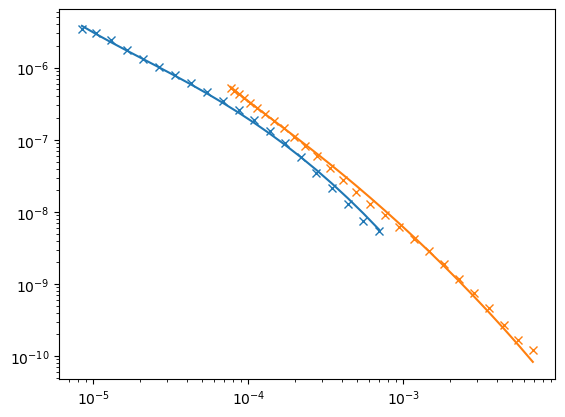

In [44]:
data_pre_2 = sim_inv2.make_synthetic_data(recovered_model_2)
plt.loglog(lm_times, -data_pre_2[src_lm, rx_lm])
plt.loglog(hm_times, -data_pre_2[src_hm, rx_hm])

plt.loglog(
    lm_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
)
plt.loglog(
    hm_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
)

We could keep going this route to add more and more layers, but at some point we start to enter the realm of underdetermined problems. I.e. when the number of model parameters exceed the number of observed data. (For this 

## Regularized inversion

Let's keep building off of the pieces we had before. Let's discretize our model into many different layers. But this time we will only invert for the conductivity of each layer. For this we need to set up a mesh.

In [45]:
# (start_size, number_of_cells, expansion_factor)
h = [(1.0, 64, 1.05)]
mesh = discretize.TensorMesh([h,])
mesh

TensorMesh: 64 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x     64          0.00        455.80      1.05     22.70    1.05

In [46]:
sim_reg = tdem.Simulation1DLayered(srv, sigmaMap=exp_map, thicknesses=mesh.h[0][:-1])

In [47]:
# Now we need to create an objective function that measures our model,
# This class creates a function that measures the smallness
# and the smoothness of the model.
reg = regularization.WeightedLeastSquares(mesh)

In [48]:
m_0_reg = np.full(mesh.n_cells, recovered_model[0])

In [53]:
phi_d_reg = L2DataMisfit(data=data_container, simulation=sim_reg)

# create all of the same components of the inversion problem as before
minimizer_reg = opt = optimization.InexactGaussNewton(
    maxIter=10, maxIterLS=20, maxIterCG=10, tolCG=1e-3
)

inv_prob_3 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg, beta=10
)

In [54]:
inv3 = inversion.BaseInversion(inv_prob_3, [])

# Run inversion
recovered_model_3 = inv3.run(m_0_reg)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+01  5.75e+02  5.07e-32  5.75e+02    6.10e+02      0              
   1  1.00e+01  1.04e+02  4.94e+00  1.54e+02    1.58e+02      0              
   2  1.00e+01  6.41e+01  5.48e+00  1.19e+02    2.09e+01      0   Skip BFGS  
   3  1.00e+01  6.17e+01  5.62e+00  1.18e+02    2.15e+00      0   Skip BFGS  
   4  1.00e+01  6.15e+01  5.63e+00  1.18e+02    7.36e-01      0              
   5  1.00e+01  6.14e+01  5.65e+00  1.18e+02    2.79e-01      0              
   6  1.00e+01  6.13e+01  5.65e+0

In [55]:
from SimPEG.utils import plot_1d_layer_model

(0.01, 1.0)

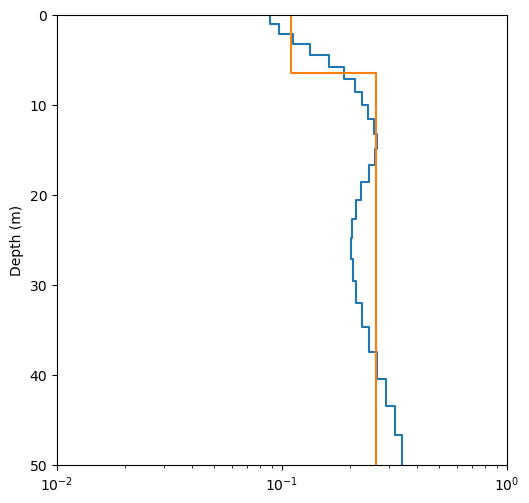

In [56]:
ax = plot_1d_layer_model(sim_reg.thicknesses, sim_reg.sigma)
plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma, ax=ax)
ax.set_ylim([50, 0])
ax.set_xlim([1E-2, 1E0])

This process of manually adjusting the regularization parameter is a bit tiresome. In SimPEG we can use `Directive`s to automate this process for us.

Say we want to decrease the regularization parameter by a factor of 5 every two iterations:

In [57]:
from SimPEG import directives

beta_cooler = directives.BetaSchedule(coolingFactor=5, coolingRate=2)

we also would likely want to keep track of the model and the function values at each iteration

In [58]:
save_dict = directives.SaveOutputDictEveryIteration()

We combine these into a list, and pass them to the inversion.

In [59]:
# create all of the same components of the inversion problem as before
minimizer_reg = opt = optimization.InexactGaussNewton(
    maxIter=20, maxIterLS=20, maxIterCG=100, tolCG=1e-5
)

inv_prob_4 = inverse_problem.BaseInvProblem(
    phi_d_reg, reg=reg, opt=minimizer_reg, beta=10000
)

inv4 = inversion.BaseInversion(inv_prob_4, [save_dict, beta_cooler])

# Run inversion
recovered_model_4 = inv4.run(m_0_reg)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.00e+04  5.75e+02  5.07e-32  5.75e+02    6.10e+02      0              
   1  1.00e+04  5.48e+02  1.33e-03  5.61e+02    7.98e+00      0              
   2  2.00e+03  5.48e+02  1.31e-03  5.50e+02    4.65e+02      0              
   3  2.00e+03  4.68e+02  2.42e-02  5.17e+02    2.24e+01      0              
   4  4.00e+02  4.70e+02  2.34e-02  4.79e+02    3.99e+02      0              
   5  4.00e+02  3.13e+02  2.30e-01  4.05e+02    3.95e+01      0              
   6  8.00e+01  3.16e+02  2.19e-0

In [72]:
n_iter = save_dict.opt.iter
phi_ds = [save_dict.outDict[i]['phi_d'] for i in range(1, n_iter)]
phi_ms = [save_dict.outDict[i]['phi_m'] for i in range(1, n_iter)]
betas =  [save_dict.outDict[i]['beta'] for i in range(1, n_iter)]

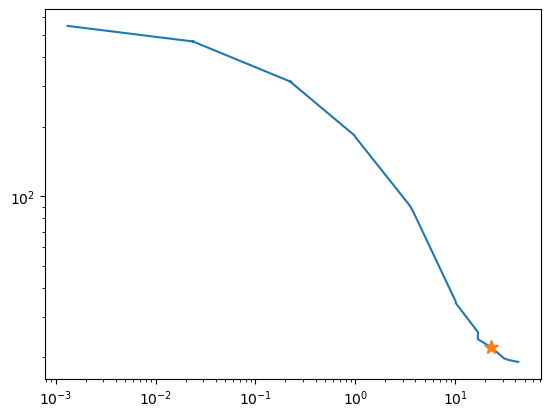

In [87]:
plt.loglog(phi_ms, phi_ds)
plt.loglog(phi_ms[14], phi_ds[14], marker='*', markersize=10)

(0.01, 1.0)

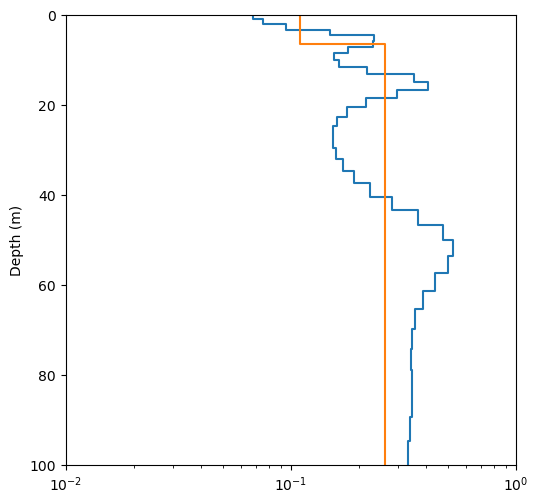

In [83]:
m_final = save_dict.outDict[14]['m']
ax = plot_1d_layer_model(sim_reg.thicknesses, exp_map * m_final)
plot_1d_layer_model(sim_inv2.thicknesses, sim_inv2.sigma, ax=ax)
ax.set_ylim([100, 0])
ax.set_xlim([1E-2, 1E0])

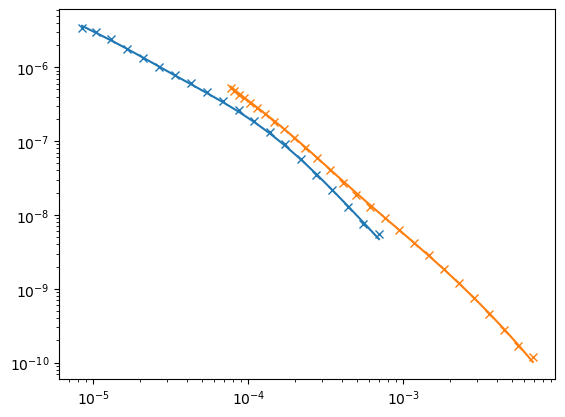

In [85]:
dpred_final = sim_reg.make_synthetic_data(m_final)

plt.loglog(lm_times, -dpred_final[src_lm, rx_lm])
plt.loglog(hm_times, -dpred_final[src_hm, rx_hm])

plt.loglog(
    lm_times, -data_container[src_lm, rx_lm], color='C0', marker='x', linestyle=""
)
plt.loglog(
    hm_times, -data_container[src_hm, rx_hm], color='C1', marker='x', linestyle=""
)

What is the noise level corresponding to this regularization parameter?
There's a few ways you can define it, let's compare the relative sizes of the data residual vector to the observed data vector.

In [94]:
rel_diff = np.abs((data_container.dobs - dpred_final.dclean)/data_container.dobs)
rel_diff.mean()

0.03105258515084411

So a 3.1% difference on average (that's not too far off from the 3% assumed relative error in the SkyTEM surveys!)